# Alignment Error Visualization

This notebook collects COM data from the database and tries to quantify some alignment errors. The main results are shown in the plots at the end of the notebook.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.ndimage import affine_transform
from skimage import measure
import SimpleITK as sitk
import matplotlib.pyplot as plt


PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)


/home/eddyod/programming/pipeline/src


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from library.controller.sql_controller import SqlController
from library.image_manipulation.filelocation_manager import FileLocationManager
from library.atlas.atlas_utilities import affine_transform_point, get_affine_transformation, \
fetch_coms, list_coms, compute_affine_transformation, affine_transform_volume
from library.atlas.brain_structure_manager import BrainStructureManager
from library.utilities.utilities_process import M_UM_SCALE, SCALING_FACTOR, random_string, \
read_image, write_image


In [4]:
def sum_square_com(com):
    ss = np.sqrt(sum([s**2 for s in com]))
    return ss

def apply_affine_transformation(volume, matrix):
    """Apply an affine transformation to a 3D volume."""
    transformed_volume = affine_transform(volume, matrix, offset=0, order=1)
    return transformed_volume

def load_ants_affine_mat(mat_file_path):
    # Load .mat file

    rotation = np.array([
    [0.941498875617981, 0.19202075898647308, -0.08786671608686447], 
    [-0.198630228638649, 0.781607985496521, 0.015325229614973068],
    [0.06243732571601868, 0.0008880351670086384, 0.8622015118598938]
    ]
    )
    translation = np.array([266.45843505859375, 150.64747619628906, -138.71780395507812])
    center = np.array([730.082275390625, 373.0629577636719, 569.5])
    # Apply rotation around center
    affine = np.eye(4)
    affine[:3, :3] = rotation
    affine[:3, 3] = translation + center - rotation @ center

    return affine

def convert_lps_to_sar(affine_lps):
    # Flip L (x) and P (y) axes: LPS to RAS => flip x and y
    flip = np.diag([-1, -1, 1, 1])
    affine_sar = flip @ affine_lps @ flip
    return affine_sar

In [13]:
moving_name = 'AtlasV8'
fixed_name = 'Allen'
moving_all = list_coms(moving_name, scaling_factor=1)
fixed_all = list_coms(fixed_name, scaling_factor=1)
common_keys = list(moving_all.keys() & fixed_all.keys())
bad_keys = ('RtTg', 'AP')
#bad_keys = ('RtTg',)
#bad_keys = ()
good_keys = set(common_keys) - set(bad_keys)

moving_src = np.array([moving_all[s] for s in good_keys])
fixed_src = np.array([fixed_all[s] for s in good_keys])
print(len(common_keys))

37


In [14]:
print(np.round(moving_src[0]))
print(np.round(fixed_src[0]))

[14248.  7211.  5459.]
[12344.  6991.  6993.]


In [15]:
#transformation_matrix = get_affine_transformation(moving_name=moving_name, fixed_name=fixed_name, 
#                                                  scaling_factor=1)
transformation_matrix = compute_affine_transformation(moving_src, fixed_src)
print(transformation_matrix)

[[ 9.77752704e-01 -3.45818301e-02  1.38903433e-02 -1.45768086e+03]
 [ 1.23304368e-01  1.25030522e+00  8.97779129e-02 -4.44177104e+03]
 [ 4.07969856e-03  1.16806694e-02  1.13418445e+00  5.14477914e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [16]:
df_list = []
error = []
transformed_dict = {}
for structure in common_keys:
    moving0 = np.array(moving_all[structure])
    fixed0 = np.array(fixed_all[structure]) 
    transformed = affine_transform_point(moving0, transformation_matrix)
    difference = [a - b for a, b in zip(transformed, fixed0)]
    ss = sum_square_com(difference)
    row = [structure, np.round(moving0), np.round(fixed0), 
           np.round(transformed), np.round(difference), ss]
    df_list.append(row)
    error.append(ss)
    transformed_dict[structure] = transformed
rms = sum(error)/len(df_list)
print(f'RMS: {rms} observations: {len(df_list)}')
# MD589 to Allen RMS 260.0211852431133
# MD585 to Allen RMS 263.314352291951
# MD594 to Allen RMS 250.79820210419254
# AtlasV8 DB to Allen RMS 238.5831606646421
# MD585 to MD589 RMS 18.2658167690059

RMS: 255.06442287466515 observations: 37


In [17]:
#transformation_matrix = np.hstack([transformation_matrix, t])
#transformation_matrix = np.vstack([transformation_matrix, np.array([0, 0, 0, 1])])
#print(transformation_matrix)
structure = 'SC'
try:
    com = moving_all[structure]
except KeyError:
    structure = common_keys[0]
    com = moving_all[structure]
#com = [1095, 392, 519]
print(f'{moving_name} {structure} non trans {np.round(np.array(com))}')
transformed_structure = affine_transform_point(com, transformation_matrix)

print(f'{moving_name} {structure} apply trans {np.round(transformed_structure/1)}')
print(f'{fixed_name} {structure} {np.round(np.array(fixed_all[structure]))}')
diff = transformed_structure - fixed_all[structure]
print(f'{moving_name}->{fixed_name} {structure} {diff}')

AtlasV8 SC non trans [10914.  3952.  4502.]
AtlasV8 SC apply trans [9139. 2250. 5711.]
Allen SC [9140. 2388. 5692.]
AtlasV8->Allen SC [  -1.5301106  -138.32410135   18.27721214]


In [18]:
columns = ['structure', moving_name, fixed_name, 'transformed', 'difference', 'sumsquares']
df = pd.DataFrame(df_list, columns=columns)
df.index.name = 'Index'
df = df.round(4)
df.sort_values(by=['sumsquares'], inplace=True)
#df.to_csv('/home/eddyod/programming/pipeline/docs/sphinx/source/_static/results.csv', index=False)
df.head(50)

,structure,AtlasV8,Allen,transformed,difference,sumsquares
Index,,,,,,
2,SNC_R,"[10137.0, 6200.0, 5706.0]","[8356.0, 5123.0, 7092.0]","[8318.0, 5072.0, 7100.0]","[-37.0, -51.0, 8.0]",63.4373
17,VLL_L,"[11287.0, 6334.0, 2911.0]","[9464.0, 5176.0, 3890.0]","[9400.0, 5131.0, 3937.0]","[-64.0, -45.0, 47.0]",91.2869
8,5N_R,"[11978.0, 6155.0, 5821.0]","[10193.0, 5286.0, 7293.0]","[10122.0, 5254.0, 7238.0]","[-71.0, -32.0, -55.0]",95.4051
21,IC,"[12238.0, 3955.0, 4419.0]","[10400.0, 2325.0, 5675.0]","[10433.0, 2409.0, 5622.0]","[33.0, 84.0, -53.0]",104.3239
34,6N_L,"[12615.0, 6264.0, 4085.0]","[10771.0, 5215.0, 5291.0]","[10717.0, 5313.0, 5273.0]","[-54.0, 98.0, -18.0]",113.3449
32,5N_L,"[12016.0, 6317.0, 3109.0]","[10193.0, 5287.0, 4092.0]","[10115.0, 5217.0, 4164.0]","[-78.0, -70.0, 72.0]",126.8206
13,3N_L,"[11014.0, 5265.0, 4302.0]","[9102.0, 3794.0, 5521.0]","[9189.0, 3885.0, 5500.0]","[86.0, 91.0, -21.0]",127.1735
29,PBG_R,"[11208.0, 4970.0, 6327.0]","[9401.0, 3846.0, 7833.0]","[9417.0, 3722.0, 7794.0]","[16.0, -124.0, -40.0]",131.0630
26,3N_R,"[11002.0, 5262.0, 4623.0]","[9103.0, 3794.0, 5864.0]","[9182.0, 3909.0, 5864.0]","[78.0, 115.0, -0.0]",139.4987


<BarContainer object of 37 artists>

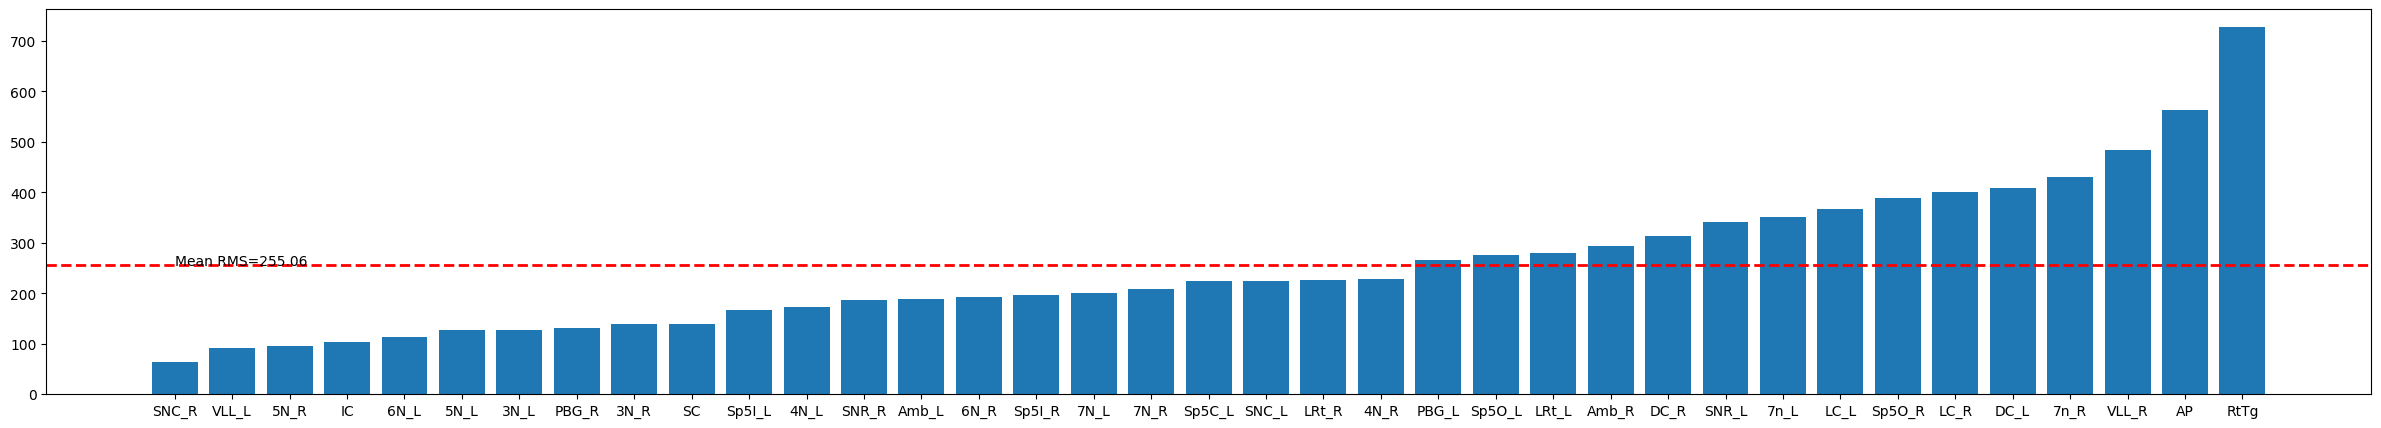

In [19]:
plt.figure(figsize=(30, 5)) 
plt.axhline(y=rms, linestyle='--', linewidth=2, color='red', label='Mean')
plt.text(0, rms, f"Mean RMS={round(rms,2)}")
plt.bar(df['structure'], df['sumsquares'])

In [ ]:
outpath = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/DK55/com'
for structure, com in moving_all.items():
    comfile = structure + '.txt'
    compath = os.path.join(outpath, comfile)
    np.savetxt(compath, com)

In [ ]:
um = 50
registration_path = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
base_com_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
for brain in [moving_name, fixed_name]:
    brain_point_path = os.path.join(registration_path, brain, f'{brain}_{um}um_sagittal.pts')
    brain_com_path = os.path.join(base_com_path, brain, 'com')
    comfiles = sorted(os.listdir(brain_com_path))
    with open(brain_point_path, 'w') as f:
        f.write('point\n')
        f.write(f'{len(common_keys)}\n')
        for comfile in comfiles:
            structure = comfile.replace('.txt','')
            if structure in common_keys:
                #print(structure)
                compath = os.path.join(brain_com_path, comfile)
                x,y,z = np.loadtxt(compath)
                f.write(f'{round(x/um,4)} {round(y/um,4)} {round(z/um,4)}')
                f.write('\n')


In [ ]:
def ants_3d_to_scipy_2d(affine_3d, plane='axial', slice_index=0):
    """
    Convert a 3D ANTs affine transformation matrix to a 2D affine transform
    suitable for scipy.ndimage.affine_transform.

    Parameters:
        affine_3d (np.ndarray): A 4x4 affine matrix from ANTs.
        plane (str): Plane to slice through ('axial', 'coronal', 'sagittal').
        slice_index (int): Index of the slice in the chosen plane.

    Returns:
        matrix_2d (np.ndarray): 2x2 affine transformation matrix.
        offset_2d (np.ndarray): Length-2 offset vector.
    """
    if affine_3d.shape != (4, 4):
        raise ValueError("Expected a 4x4 affine transformation matrix.")

    # Extract rotation+scaling and translation components
    rotation_scaling = affine_3d[:3, :3]
    translation = affine_3d[:3, 3]

    if plane == 'axial':
        matrix_2d = rotation_scaling[:2, :2]
        offset_2d = translation[:2] + rotation_scaling[:2, 2] * slice_index
    elif plane == 'coronal':
        matrix_2d = rotation_scaling[[0,2], :][:, [0,2]]
        offset_2d = translation[[0,2]] + rotation_scaling[[0,2], 1] * slice_index
    elif plane == 'sagittal':
        matrix_2d = rotation_scaling[1:3, 1:3]
        offset_2d = translation[1:3] + rotation_scaling[1:3, 0] * slice_index
    else:
        raise ValueError("Plane must be 'axial', 'coronal', or 'sagittal'.")

    return matrix_2d, offset_2d

In [ ]:
reg_path = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
matrix_path = os.path.join(reg_path, 'ALLEN771602/ALLEN771602_Allen_32.0x28.8x28.8um_sagittal.tfm')
transform = sitk.ReadTransform(matrix_path)

In [ ]:
tx = sitk.AffineTransform(transform)
Rt = tx.GetMatrix()
R = np.array(Rt).reshape(3,3)
print(R)
print()
Rr = np.rot90(R, k=1)
print(Rr)

In [ ]:
affine_transform = sitk.AffineTransform(3)
affine_transform.SetMatrix(Rr.flatten())
affine_transform.SetTranslation(t)
affine_transform.SetCenter(c)


In [ ]:
# Example 3x3 array where each row is a 3D point
A = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# Rotation matrix for 90 degrees around Y-axis (counter-clockwise)
theta = np.radians(90)
rotation_matrix = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0,            1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
])

# Apply rotation
rotated = A @ rotation_matrix.T
print(rotated)

In [ ]:
rotation_matrix.T